<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Sporting%20Goods%20Stores%20US/Sarima%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sqlalchemy
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.5 MB/s 
     |████████████████████████████████| 9.8 MB 39.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from sqlalchemy import create_engine
from urllib.parse import quote
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 


In [5]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='45111'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

In [6]:
df.to_excel('Data MarketSize - USCensus.xlsx')

In [7]:
df = df[['ds', 'y']][df['ds'] > '2010-01-01']

In [8]:
df = df.set_index('ds')
df.index.freq = 'M'

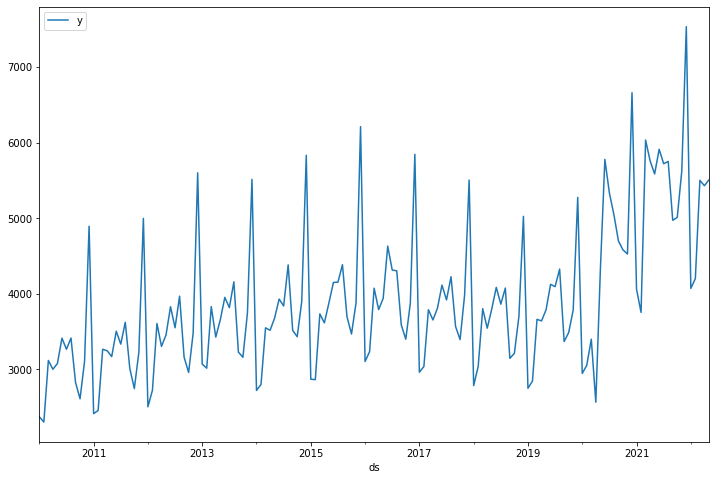

In [9]:
df.plot(figsize=(12,8))

In [10]:
res = seasonal_decompose(df, model='additive')

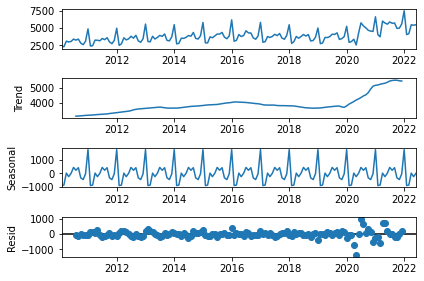

In [11]:
res.plot();

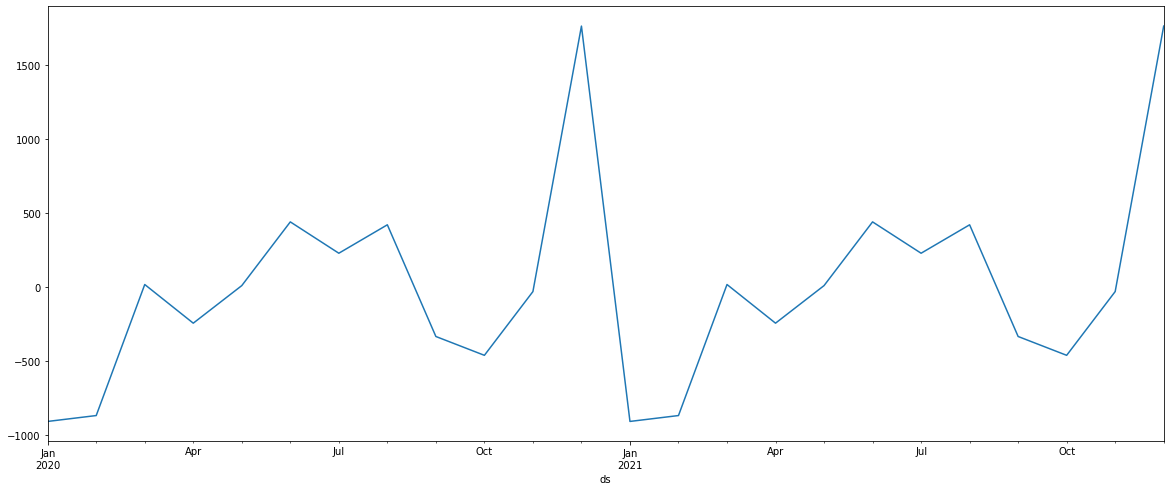

In [12]:
res.seasonal["2020":"2021"].plot(figsize=(20,8));

In [13]:
auto_arima(y=df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2101.298, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1994.513, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2010.148, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2119.437, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2017.871, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1991.992, Time=2.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2101.750, Time=1.40 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1993.990, Time=2.73 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1992.833, Time=2.98 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2012.273, Time=2.05 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1988.887, Time=3.14 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  149
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -979.618
Date:                            Mon, 25 Jul 2022   AIC                           1973.235
Time:                                    10:10:39   BIC                           1993.675
Sample:                                         0   HQIC                          1981.542
                                            - 149                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     46.5575     34.201      1.361      0.173     -20.475     113.590
ar.L1          0.7641      0.039     19.396      0.000       0.687       0.841
ar.L2         -0.3081      0.071     -4.349      0.000      -0.447      -0.169
ar.L3          0.3910      0.069      5.675      0.000       0.256       0.526
ar.S.L12      -0.5605      0.077     -7.291      0.000      -0.711      -0.410
ar.S.L24      -0.2564      0.126     -2.039      0.041      -0.503      -0.010
sigma2      8.467e+04   6366.896     13.298      0.000    7.22e+04    9.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               354.95
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               5.92   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
sxorder = (3,0,0)
sxsorder = (2,0,1,12)

In [15]:
def testmodel(train, test):
    print('train end: ', train.index[-1])
    
    print('\n---------\n')

    model = SARIMAX(endog=train, order=sxorder, seasonal_order=sxsorder).fit(disp=0)

    test['ypred'] = model.predict(start=test.index[0], end=test.index[-1])

    mape = round(np.mean(np.abs((test['y'] - test['ypred'])/test['y'])),3)
    accuracy = round((1-mape)*100,1)
    print('Accuracy: ', accuracy)

    print('\n---------\n')

    dffcast = model.get_forecast(steps=24).summary_frame()
    dffcast['bounds'] = round((pd.to_numeric(dffcast['mean_ci_upper'])-pd.to_numeric(dffcast['mean_ci_lower']))/pd.to_numeric(dffcast['mean'])*100)
    print(dffcast[['mean_ci_lower', 'mean', 'mean_ci_upper', 'bounds']])
    
    print('\n---------\n')
    
    test['mape'] = (1-round(abs(test['y'] - test['ypred'])/test['y'],6))*100
    test[['y', 'ypred', 'mape']]
    print(test[['y', 'ypred', 'mape']])

In [16]:
df[:-48]

,y
ds,
2010-01-31,2373.0
2010-02-28,2303.0
2010-03-31,3118.0
2010-04-30,3001.0
2010-05-31,3078.0
...,...
2018-01-31,2785.0
2018-02-28,3038.0
2018-03-31,3803.0


In [17]:
testmodel(df[:-48], df[-48:])

train end:  2018-05-31 00:00:00

---------



LinAlgError: ignored

In [28]:
model = SARIMAX(endog=df, order=sxorder, seasonal_order=sxsorder).fit(disp=0)
pred = model.get_forecast(steps=51).summary_frame()

In [29]:
dffin = pd.DataFrame(index=pd.date_range(df.index[0], pred.index[-1], freq='M'))

In [30]:
dffin['y'] = df['y']
dffin['ypred'] = pred['mean']

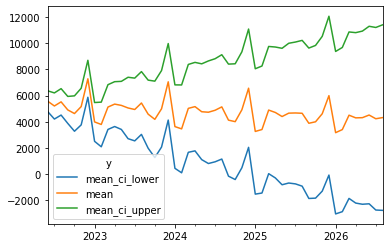

In [31]:
pred[['mean_ci_lower', 'mean', 'mean_ci_upper']].plot()

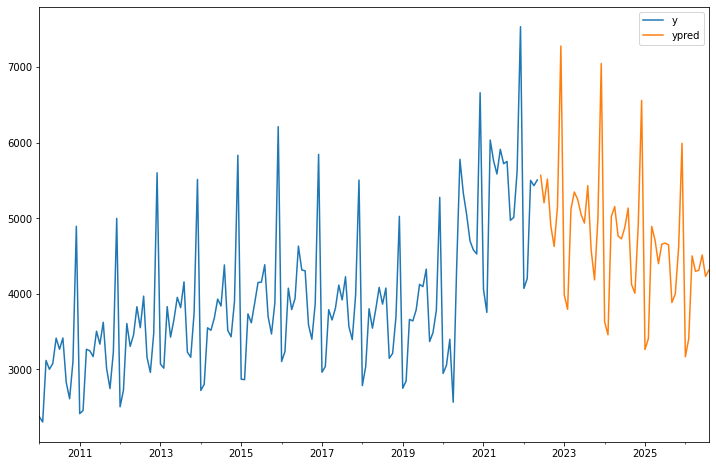

In [32]:
dffin.plot(figsize=(12,8))

In [33]:
pred

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-06-30,5568.262730,404.296022,4775.857088,6360.668373
2022-07-31,5203.765739,508.769226,4206.596380,6200.935097
2022-08-31,5518.756542,514.173846,4510.994322,6526.518762
2022-09-30,4903.302044,525.290514,3873.751555,5932.852534
2022-10-31,4626.687830,688.953005,3276.364753,5977.010906
2022-11-30,5158.658269,713.160700,3760.888982,6556.427557
2022-12-31,7279.009729,719.419194,5868.974019,8689.045438
2023-01-31,3986.996580,754.924881,2507.371002,5466.622159
2023-02-28,3794.158363,868.971031,2091.006438,5497.310287
2023-03-31,5121.377299,870.981834,3414.284273,6828.470326


In [34]:
pred = pred[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred.columns = ['Projection', 'Lower Bound', 'Upper Bound']
pred.to_excel('Spoting Goods Stores Projected MarketSize - USCensus.xlsx')